# Toy Visual Classification Example
We consider 2 bivariate toy classification problems where the highest accuracy achievable is known. 

We show that the data valuation analysis of the `kxy` package is able to recover the highest classification accuracy achievable almost perfectly. Additionally, we train 10 popular classifiers on the data, and we show that the model-driven improvability analysis provided the `kxy` package accurately captures the extent to which each trained model can be improved.

In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

# Required imports
import pandas as pd
import seaborn as sns
import kxy

## I - Generate the data

In [2]:
p = 0.1 # Error probability
n = 2000 # Sample size

### Quadrant Data

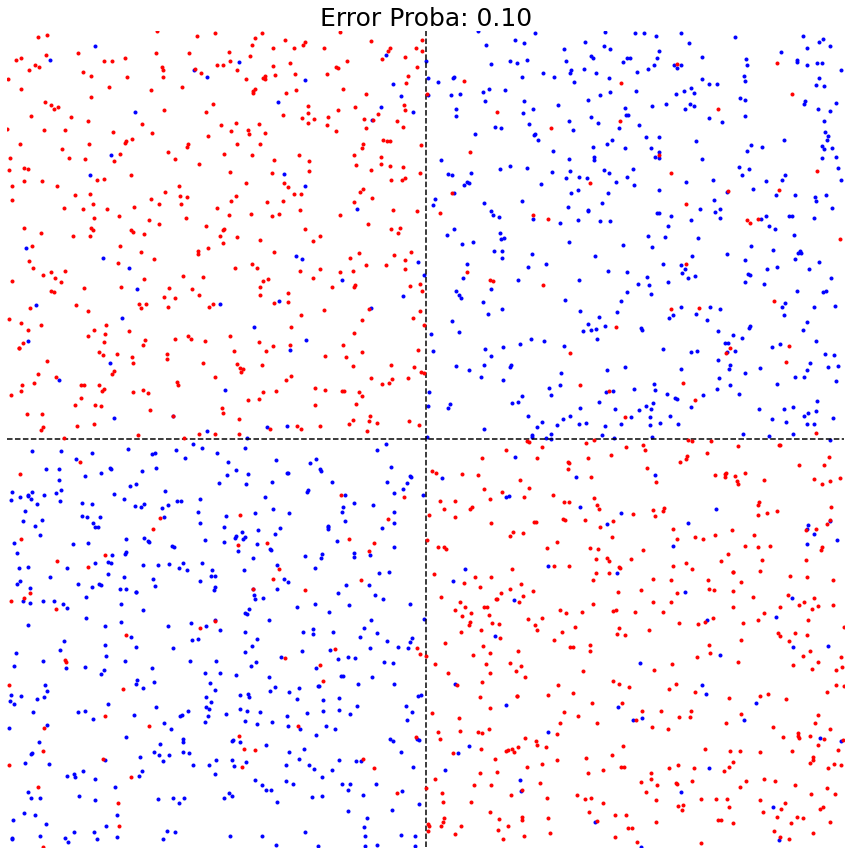

In [3]:
# Generate
u = -1.+2.*np.random.rand(n, 2)
perm = np.random.rand(n)<p
b = np.zeros(n)
b[perm] = np.logical_or(np.logical_and(u[perm, 0] < 0., u[perm, 1] > 0.), \
                        np.logical_and(u[perm, 0] > 0., u[perm, 1] < 0.))
b[np.logical_not(perm)] = np.logical_or(np.logical_and(\
                                u[np.logical_not(perm), 0] > 0.,\
                                u[np.logical_not(perm), 1] > 0.), \
                                np.logical_and(u[np.logical_not(perm), 0] < 0., u[np.logical_not(perm), 1] < 0.))

b = b.astype(bool)
r = np.logical_not(b)
zb = u[b, :]
zr = u[r, :]
yb = np.ones(zb.shape[0])
yr = np.zeros(zr.shape[0])
Xq = np.concatenate([zb, zr], axis=0)
Yq = np.concatenate([yb, yr], axis=0)
Zq = np.concatenate([Yq[:, None], Xq], axis=1)
# Numpy -> DataFrame
dfq = pd.DataFrame(Zq, columns=['label', 'var1', 'var2'])

# Plot
x_border = np.zeros(21)
y_border = np.arange(-1., 1.1, 0.1)
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
plt.plot(zb[:, 0], zb[:, 1], '.b')
plt.plot(x_border, y_border, '--k')
plt.plot(y_border, x_border, '--k')
plt.plot(zr[:, 0], zr[:, 1], '.r')
ax.set_xlim([-1., 1.])
ax.set_ylim([-1., 1.])
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.axis('off')
ax.set_title(r'Error Proba: %.2f'% (p), fontsize=25)
plt.show()

### Circular Data

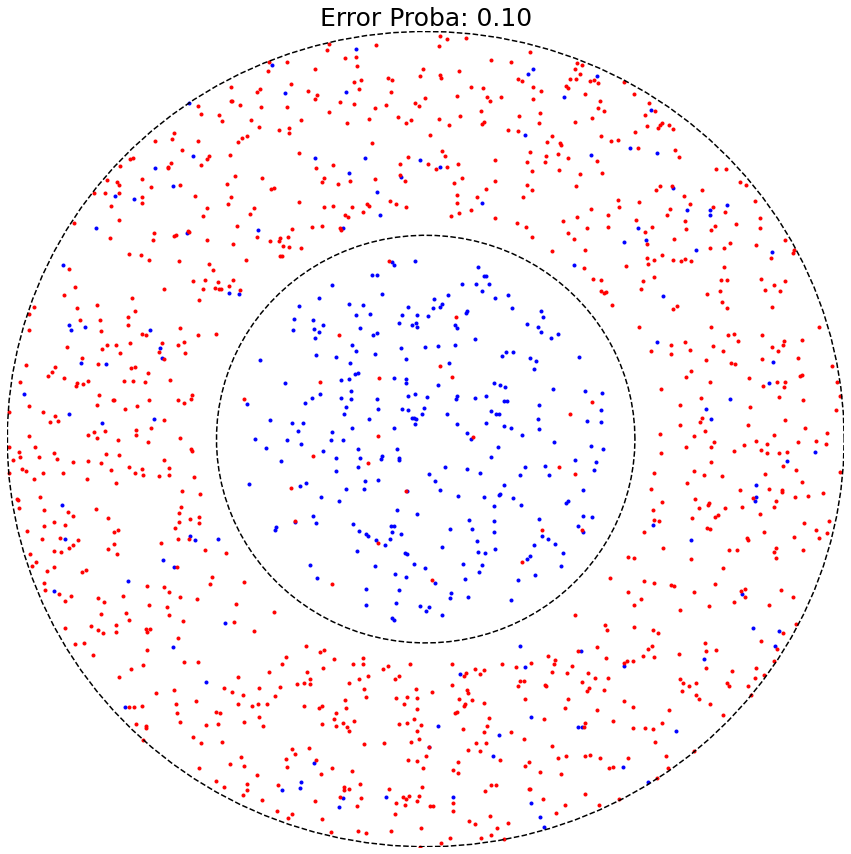

In [4]:
# Generate the data
dr = 0.05
u = -1.+2.*np.random.rand(n, 2)
perm = np.random.rand(n)<p
b = np.zeros(n)
b[perm] = np.logical_and(np.linalg.norm(u[perm], axis=1)>0.5+dr, np.linalg.norm(u[perm], axis=1)<1.)
b[np.logical_not(perm)] = np.linalg.norm(u[np.logical_not(perm)], axis=1)<0.5-dr
b = b.astype(bool)
r = np.logical_and(np.logical_not(b), np.linalg.norm(u, axis=1)<1.)
r = np.logical_and(r, np.logical_or(np.linalg.norm(u, axis=1)<0.5-dr, np.linalg.norm(u, axis=1)>0.5+dr))
z = u[np.linalg.norm(u, axis=1)<1., :]

zb = u[b, :]
zr = u[r, :]
yb = np.ones(zb.shape[0])
yr = np.zeros(zr.shape[0])
Xc = np.concatenate([zb, zr], axis=0)
Yc = np.concatenate([yb, yr], axis=0)
Zc = np.concatenate([Yc[:, None], Xc], axis=1)

# Numpy -> DataFrame
dfc = pd.DataFrame(Zc, columns=['label', 'var1', 'var2'])

# Plot
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
theta = np.linspace(0, 2.*np.pi, 100)
r1, r2 = 0.5, 1.0
xc1, yc1 = r1*np.cos(theta), r1*np.sin(theta)
xc2, yc2 = r2*np.cos(theta), r2*np.sin(theta)

plt.plot(zb[:, 0], zb[:, 1], '.b')
plt.plot(zr[:, 0], zr[:, 1], '.r')
plt.plot(xc1, yc1, '--k')
plt.plot(xc2, yc2, '--k')
ax.set_xlim([-1., 1.])
ax.set_ylim([-1., 1.])
ax.axis('off')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_title(r'Error Proba: %.2f'% (p), fontsize=25)
plt.show()

## II - Data Valuation

### Quadrant Data

In [5]:
dfq.kxy.data_valuation('label', problem_type='classification')

[====================================================================================================] 100% ETA: 0s   


Achievable R-Squared Achievable Log-Likelihood Per Sample  \
0                 0.52                            -3.27e-01   

  Achievable Accuracy  
0                0.90

### Circular Data

In [6]:
dfc.kxy.data_valuation('label', problem_type='classification')

[====================================================================================================] 100% ETA: 0s   


Achievable R-Squared Achievable Log-Likelihood Per Sample  \
0                 0.42                            -3.16e-01   

  Achievable Accuracy  
0                0.90

## III - Model-Driven Improvability

### Step 1: we train a wide range of scikit-learn classifiers 

<Figure size 1944x648 with 0 Axes>

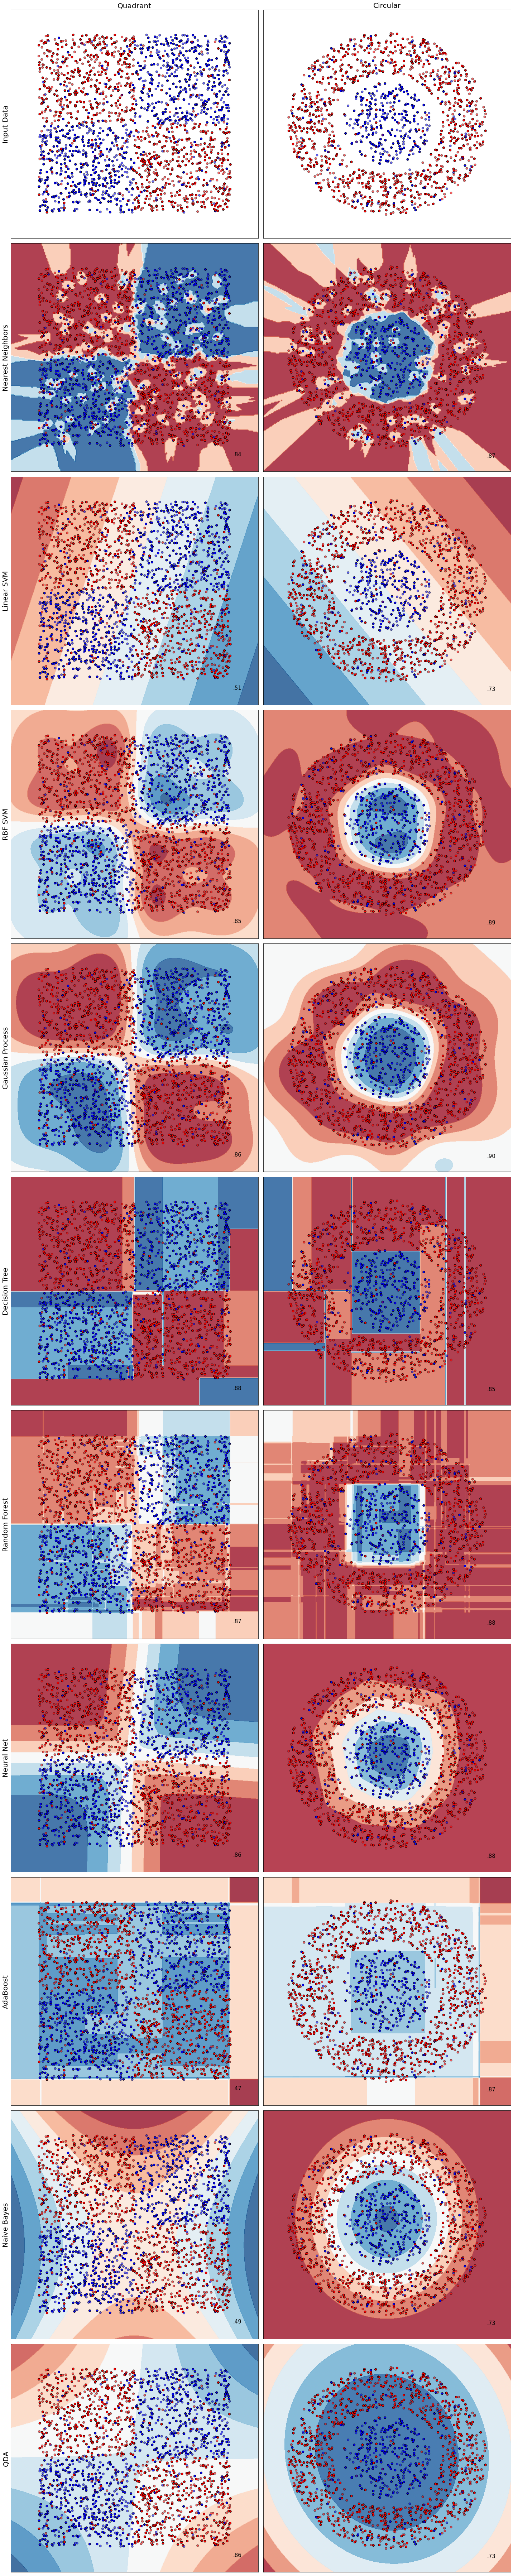

In [7]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

figure = plt.figure(figsize=(27, 9))
ds_cnt = 0
datasets = [(Xq, Yq), (Xc, Yc)]
dataset_names = ['Quadrant', 'Circular']
fig, axes = plt.subplots(len(classifiers)+1, len(datasets), figsize=(20, 100))
dfs = []
# Iterate over datasets
for _ in range(len(datasets)):
    i=0
    X, y = datasets[_]
    # Preprocess dataset, split into training and test part
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = axes[i, _]
    ax.set_title(dataset_names[_], fontsize=20)
    if ds_cnt == 0:
        ax.set_ylabel('Input Data', fontsize=20)
        
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1
    
    df = pd.DataFrame({'x_0': X_test[:, 0], 'x_1': X_test[:, 1], 'y': y_test})
    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = axes[i, _]
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        df[name + ' Prediction'] = clf.predict(X_test)

        # Plot the decision boundary.
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_ylabel(name, fontsize=20)
            
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1
    ds_cnt = 1
    dfs += [df.copy()]     

plt.tight_layout()

### Step 2: we verify their estimated model-driven improvability

In [8]:
# Estimate lost accuracy for all models and both datasets using the kxy package
all_lost_accuracy = pd.DataFrame({
    name: [dfs[i][['x_0', 'x_1', 'y', name + ' Prediction']].kxy.model_driven_improvability(\
        'y', name + ' Prediction', problem_type='classification')\
        ['Lost Accuracy'][0] for i in range(len(datasets))] for name in names})

all_lost_accuracy['Dataset ==>'] = ['Quadrant', 'Circular']
all_lost_accuracy.set_index(['Dataset ==>'], inplace=True)

[====================================================================================================] 100% ETA: 0s   
[====================================================================================================] 100% ETA: 0s   
[====================================================================================================] 100% ETA: 0s   
[====================================================================================================] 100% ETA: 0s   
[====================================================================================================] 100% ETA: 0s   
[====================================================================================================] 100% ETA: 0s   
[====================================================================================================] 100% ETA: 0s   
[====================================================================================================] 100% ETA: 0s   
[===============================================

In [9]:
cm = sns.light_palette("red", as_cmap=True)
all_lost_accuracy.astype(float).T\
.style.background_gradient(cmap=cm)\
.set_caption("Tab 1: Amount of classification accuracy each model "\
             "missed out on.")

Our improvability analysis seems spot-on, both in relative terms and in magnitude!